# Import

In [1]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
import pickle


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


device =  cuda


In [2]:
print(STOPWORDS)

{'needn', 'yours', 'again', 'same', 'this', 'most', 'myself', 'above', 'more', 'here', "aren't", 'these', 'any', 'mustn', 'them', 'a', 'below', 'until', 'm', 'your', "haven't", 'did', "that'll", 'both', 'so', 'they', 'not', 'my', 'hadn', 'are', 'our', 'being', 're', "didn't", "needn't", 'you', 'its', 'all', 'that', 'weren', 'yourselves', 'mightn', "weren't", 'having', 'doesn', 'now', "mustn't", 'her', 'nor', 'itself', 'herself', 'he', 'but', 'because', 'further', 'hasn', 've', 'from', 'the', 'were', 'had', 'very', "you're", "hadn't", 't', 'wasn', "won't", 'themselves', 'do', 'does', 'some', 'just', 'wouldn', 'through', 'been', 'about', 'shouldn', 'where', 'on', 'an', 'won', 'couldn', 'can', "hasn't", 'for', 'those', "you'd", 'when', 's', 'and', "you've", 'too', 'if', 'which', 'then', 'once', "should've", 'ain', 'should', 'up', 'o', "she's", 'y', 'in', 'during', 'himself', 'no', 'it', 'ours', 'own', 'she', 'yourself', 'what', 'am', 'after', "mightn't", "doesn't", 'who', 'than', 'd', 'he

#  Hyperparams

In [3]:
ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'amazon_full' )
ALL_DF_CSV = os.path.join(DATASET_PATH, 'all_df.csv')

OUTPUT_PATH = os.path.join(ROOT, 'output', 'bert')

TRAIN_DATAPATH = os.path.join(DATASET_PATH, 'train.csv')
TEST_DATAPATH = os.path.join(DATASET_PATH, 'test.csv')

SAMPLE_SIZE = 0.05
TEST_SAMPLE_SIZE = 0.01

CLEANED_TRAIN_DATAPATH = os.path.join(DATASET_PATH, f'cleaned_train_{int(SAMPLE_SIZE*100)}%.csv')
CLEANED_TEST_DATAPATH = os.path.join(DATASET_PATH, f'cleaned_test_{int(TEST_SAMPLE_SIZE*100)}%.csv')

if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)


# Load the whole dataset and truncate it (for experiments)

In [4]:
# train_txt = bz2.BZ2File(os.path.join(datasetpath, 'train.ft.txt.bz2'))
# train_txt = bz2.BZ2File('/content/drive/MyDrive/UB/Sem 2/DL/DL FINAL Project/train.ft.txt.bz2')

# train_txt = bz2.BZ2File(DATASET_PATH)
# train_lines = train_txt.readlines()

In [5]:
train_df = pd.read_csv(TRAIN_DATAPATH, names = ["review", "title","text"])
train_df = train_df.sample(frac = SAMPLE_SIZE)
train_df.reset_index(inplace = True, drop = True)
train_df.head()
# print(train_df.shape)
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
train_df['review'] = train_df['review'].map(label_map)
print(train_df.shape)
print(train_df['review'].value_counts())
train_df.head()

(150000, 3)
review
2    30204
3    30039
0    29986
4    29962
1    29809
Name: count, dtype: int64


,review,title,text
0,1,"No vosotros forms, but better than nothing - m...",I was terribly disappointed to find that the v...
1,1,Good while it lasts (which isn't very long),"Like other posters here, I have had ongoing pr..."
2,2,NOT the definitive guide (on the measurement o...,This book covers a wide variety of FROG method...
3,4,love it,bought this because i was tired of peeling and...
4,2,"A good planner, but NOT a Journal",I bought this because I did want something wha...


In [6]:
test_df = pd.read_csv(TEST_DATAPATH, names = ["review", "title","text"])
test_df = test_df.sample(frac = TEST_SAMPLE_SIZE)
test_df.reset_index(inplace = True, drop = True)
test_df.head()
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
test_df['review'] = test_df['review'].map(label_map)
test_df.reset_index(inplace=True, drop = True)
print(test_df['review'].value_counts())
print(test_df.shape)
test_df.head()

review
3    1344
4    1309
2    1300
1    1290
0    1257
Name: count, dtype: int64
(6500, 3)


,review,title,text
0,3,What can I say?,This book was the first decent book I have rea...
1,2,Cool,"This is a cool CD, not the best. Some songs ar..."
2,1,Very used,If the seller would told me the book was writt...
3,3,A great gamble,It's strange how you come across good books. I...
4,1,"Sorry to Say, I Couldn't Give a . . .","Produced by Jimmy Buffett, and based on Carl H..."


# Clean text

In [7]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    # text = remove_stopwords(text)

    #__label__1 = 0: bad review, __label__2 = 1,good review
    text = ' '.join(t for t in text.split() if t != '')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)

'this is a test string here are some special characters how about some punctuations _'

# Build array

In [8]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 800):
    X_tokens = []
    X_lengths = []
    max_len = 0
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        max_len = max(max_len, len(tokens))
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    print('max len = ', max_len)
    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 2, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor(labels)
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id


In [9]:
# all_df = pd.concat([train_df, test_df])

# X_array = all_df['text'].values
# y_array = all_df['review'].values

# (train_tokens, train_ids, train_y, train_lengths) ,vocab, pad_id = build_train_test_data(X_array, y_array)

# train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

# print('ids shape = ', train_ids.shape )
# print('y values = ', set(train_y.tolist()) )
# print('y shape = ', train_y.shape )
# print('lengths shape = ', train_lengths.shape)

100%|██████████| 156500/156500 [00:06<00:00, 23504.44it/s]


max len =  405
vocab len =  77137


100%|██████████| 156500/156500 [00:04<00:00, 34099.73it/s]


ids shape =  torch.Size([156500, 405])
y values =  {0, 1, 2, 3, 4}
y shape =  torch.Size([156500])
lengths shape =  torch.Size([156500])


# Check data integrity, missing values and bad values

In [10]:
print('train df')
train_df.dropna(inplace=True)
print(train_df.isna().sum())
print('train df = ', train_df.shape)
print('test df')
test_df.dropna(inplace=True)
print(test_df.isna().sum())
print('test df = ' ,test_df.shape)

train df
review    0
title     0
text      0
dtype: int64
train df =  (149992, 3)
test df
review    0
title     0
text      0
dtype: int64
test df =  (6499, 3)


# Save df

In [11]:
train_df.to_csv(CLEANED_TRAIN_DATAPATH, index=False)
test_df.to_csv(CLEANED_TEST_DATAPATH, index=False)


In [12]:
print(test_df.shape)
test_df.head()

(6499, 3)


,review,title,text
0,3,What can I say?,This book was the first decent book I have rea...
1,2,Cool,"This is a cool CD, not the best. Some songs ar..."
2,1,Very used,If the seller would told me the book was writt...
3,3,A great gamble,It's strange how you come across good books. I...
4,1,"Sorry to Say, I Couldn't Give a . . .","Produced by Jimmy Buffett, and based on Carl H..."


In [13]:
# eda_df = train_df.copy()
# eda_df['text'] = eda_df['text'].apply(lambda s: clean_text(s))
train_df['lengths'] = train_df['text'].apply(lambda s: len(s))
test_df['lengths'] = test_df['text'].apply(lambda s: len(s))


# Stats
train_df.describe()

,review,lengths
count,149992.000000,149992.000000
mean,2.001187,413.437343
std,1.413369,236.865098
min,0.000000,27.000000
25%,1.000000,213.000000
50%,2.000000,366.000000
75%,3.000000,579.000000
max,4.000000,1009.000000


In [14]:
test_df.describe()

,review,lengths
count,6499.000000,6499.000000
mean,2.024004,417.708417
std,1.408448,236.586270
min,0.000000,32.000000
25%,1.000000,217.000000
50%,2.000000,375.000000
75%,3.000000,584.000000
max,4.000000,1006.000000


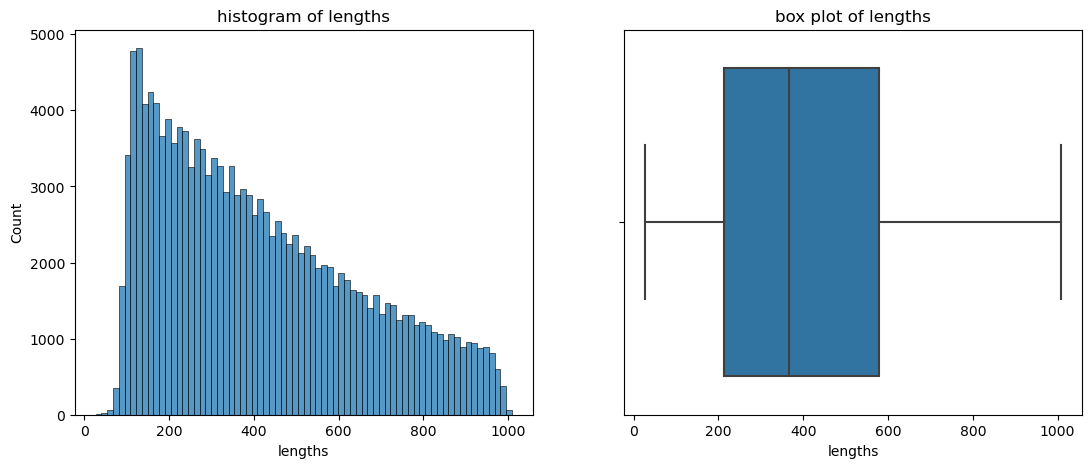

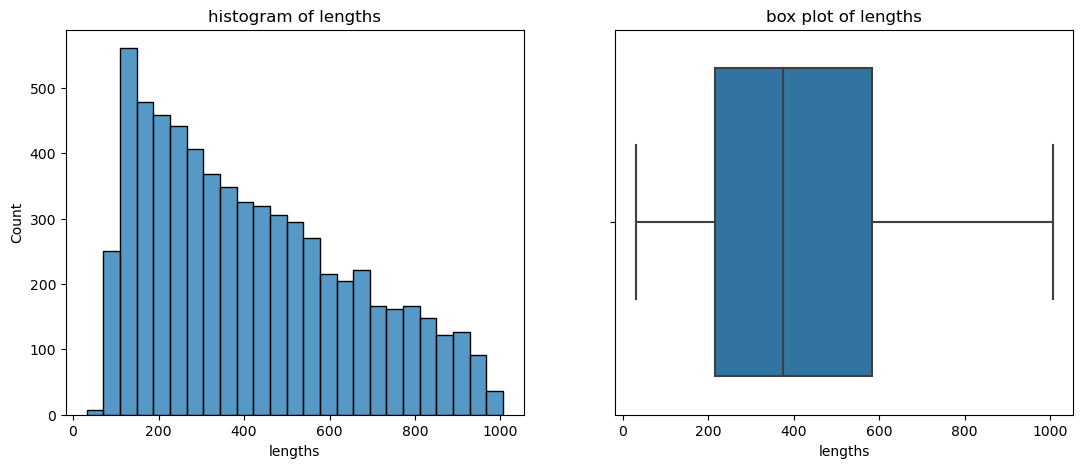

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.histplot(train_df, x = 'lengths', ax = ax1)
ax1.set_title('histogram of lengths')
sns.boxplot(train_df, x = 'lengths', ax = ax2)
ax2.set_title('box plot of lengths')
plt.show()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.histplot(test_df, x = 'lengths', ax = ax1)
ax1.set_title('histogram of lengths')
sns.boxplot(test_df, x = 'lengths', ax = ax2)
ax2.set_title('box plot of lengths')
plt.show()

# A little EDA

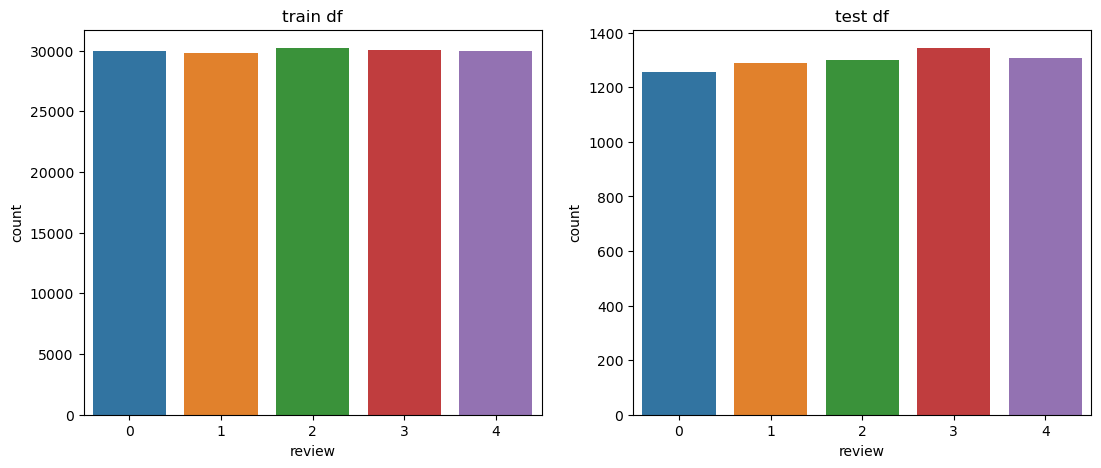

In [16]:
# bad_reviews = eda_df.loc[eda_df['review'] == 1]['text'].apply(lambda s: len(s)).values
# good_reviews = eda_df.loc[eda_df['review'] == 2]['text'].apply(lambda s: len(s)).values
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.countplot(train_df, x = 'review', ax = ax1)
ax1.set_title('train df')
sns.countplot(test_df, x = 'review', ax = ax2)
ax2.set_title('test df')
plt.show()